# Read Dataset

In [1]:
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")

trd = pd.read_csv("Desktop/training_set.csv")
tsd = pd.read_csv("Desktop/testing_set.csv")

In [2]:
trd.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N


In [3]:
tsd.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban


# Profiling

In [4]:
trd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             599 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          613 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    612 non-null    float64
 7   CoapplicantIncome  613 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), object(8)
memory usage: 62.5+ KB


In [5]:
Q = trd.nunique().sort_values()
Q1 = list(Q[Q<11].index)

In [6]:
trd[Q1].head()

,Gender,Married,Education,Self_Employed,Credit_History,Loan_Status,Property_Area,Dependents,Loan_Amount_Term
0,Male,No,Graduate,No,1.0,Y,Urban,0,360.0
1,Male,Yes,Graduate,No,1.0,N,Rural,1,360.0
2,Male,Yes,Graduate,Yes,1.0,Y,Urban,0,360.0
3,Male,Yes,Not Graduate,No,1.0,Y,Urban,0,360.0
4,Male,No,Graduate,No,1.0,Y,Urban,0,360.0


# Missing Data treatment

In [7]:
Q = trd.isna().sum()
Q[Q>0]

Gender               15
Married               3
Dependents           15
Education             1
Self_Employed        32
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
dtype: int64

In [8]:
Q = tsd.isna().sum()
Q[Q>0]

Gender              11
Dependents          10
Self_Employed       23
LoanAmount           5
Loan_Amount_Term     6
Credit_History      29
dtype: int64

In [9]:
cat = []
con = []
for i in trd.columns:
    if(trd[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

In [10]:
cat

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [11]:
con

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [12]:
trd[cat].nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [13]:
trd[con].nunique()

ApplicantIncome      504
CoapplicantIncome    286
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
dtype: int64

In [14]:
con.remove("Credit_History")
cat.append("Credit_History")

In [15]:
for i in con:
    x = trd[i].mean()
    trd[i]=trd[i].fillna(x)
    tsd[i]=tsd[i].fillna(x)

In [16]:
for i in cat:
    x = trd[i].mode()[0]
    trd[i]=trd[i].fillna(x)
    if(i!="Loan_Status"):
        tsd[i]=tsd[i].fillna(x)

In [17]:
Q = trd.isna().sum()
Q[Q>0]

Series([], dtype: int64)

In [18]:
Q = tsd.isna().sum()
Q[Q>0]

Series([], dtype: int64)

# Outliers


In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Q = pd.DataFrame(ss.fit_transform(trd[con]),columns=con)

In [20]:
out = []
for i in con:
    out = out + list(Q[(Q[i]>3)|(Q[i]<-3)].index)

In [21]:
from numpy import unique
outliers = list(unique(out))

In [22]:
trd = trd.drop(index=outliers,axis=0)

In [23]:
trd.shape

(577, 13)

In [24]:
trd.index = range(0,577,1)

# EDA

In [25]:
def ANOVA(df,cat,con):
    from statsmodels.formula.api import ols
    eqn = str(con) + " ~ " + str(cat)
    model = ols(eqn,df).fit()
    from statsmodels.stats.anova import anova_lm
    Q = anova_lm(model)
    return round(Q.iloc[0:1,4:5].values[0][0],5)

def chisq(df,cat1,cat2):
    import pandas as pd
    from scipy.stats import chi2_contingency
    ct = pd.crosstab(df[cat1],df[cat2])
    a,b,c,d = chi2_contingency(ct)
    return round(b,5)

In [26]:
for i in con:
    pval = ANOVA(trd,'Loan_Status',i)
    print("Loan_Status vs",i,"-----> pval =",pval)

Loan_Status vs ApplicantIncome -----> pval = 0.89434
Loan_Status vs CoapplicantIncome -----> pval = 0.28206
Loan_Status vs LoanAmount -----> pval = 0.3975
Loan_Status vs Loan_Amount_Term -----> pval = 0.66362


In [27]:
for i in cat:
    pval = chisq(trd,'Loan_Status',i)
    if(pval<0.05 and i!='Loan_Status'):
        print("Loan_Status vs",i,"-----> pval =",pval)

Loan_Status vs Married -----> pval = 0.04094
Loan_Status vs Education -----> pval = 0.03415
Loan_Status vs Property_Area -----> pval = 0.00232
Loan_Status vs Credit_History -----> pval = 0.0


# Preprocessing and Data preparation

In [28]:
X = trd[["CoapplicantIncome","Married","Education","Property_Area","Credit_History"]]
Y = trd[["Loan_Status"]]
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(X[["CoapplicantIncome"]]),columns=["CoapplicantIncome"])
X2 = pd.get_dummies(X[["Married","Education","Property_Area","Credit_History"]])
Xnew = X1.join(X2)
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

# Model 1

In [29]:
def modeller(mo):
    model = mo.fit(xtrain,ytrain)
    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)
    from sklearn.metrics import accuracy_score
    tr_acc = round(accuracy_score(ytrain,pred_tr),2)
    ts_acc = round(accuracy_score(ytest,pred_ts),2)
    return tr_acc,ts_acc

In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeller(lr)

(0.81, 0.84)

# Model 2

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)
modeller(dtc)

(0.9, 0.72)

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11,max_depth=2)
modeller(dtc)

(0.81, 0.84)

In [33]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11,max_depth=3)
modeller(dtc)

(0.81, 0.84)

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11,max_depth=4)
modeller(dtc)

(0.82, 0.78)

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20)
modeller(rfc)

(0.89, 0.78)

In [36]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20,max_depth=2)
modeller(rfc)

(0.81, 0.84)

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20,max_depth=3)
modeller(rfc)

(0.81, 0.84)

# Part 3

In [38]:
trd.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.00000,0.0,146.412162,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,5405.54085,1508.0,128.000000,360.0,1.0,Rural,N


In [39]:
X = trd.drop(labels=["Loan_ID","Loan_Status"],axis=1)
cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)
        
Y = trd[["Loan_Status"]]
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)
X2 = pd.get_dummies(X[cat])
Xnew = X1.join(X2)
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

In [40]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11)
modeller(dtc)

(1.0, 0.71)

In [41]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11,max_depth=2)
modeller(dtc)

(0.81, 0.84)

In [42]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=11,max_depth=3)
modeller(dtc)

(0.83, 0.83)

In [43]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20)
modeller(rfc)

(1.0, 0.8)

In [44]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20,max_depth=3)
modeller(rfc)

(0.81, 0.84)

In [45]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=40)
modeller(abc)

(0.97, 0.72)

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
modeller(knc)

(0.83, 0.83)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=2)
modeller(knc)

(0.9, 0.67)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=3)
modeller(knc)

(0.87, 0.77)

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=5)
modeller(knc)

(0.83, 0.83)

# Train the model with entire Data

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=5)
model = knc.fit(Xnew,Y)

# Data preparation for testing set

In [51]:
W = tsd.drop(labels=["Loan_ID"],axis=1)

cat = []
con = []
for i in W.columns:
    if(W[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

X11 = pd.DataFrame(ss.transform(W[con]),columns=con)
X21 = pd.get_dummies(W[cat])
Xnew2 = X11.join(X21)

In [52]:
DF2 = pd.DataFrame(Xnew2.columns,columns=["Q"]).sort_values(by="Q")

In [53]:
len(Xnew.columns)

20

In [54]:
len(Xnew2.columns)

20

# Predictions

In [55]:
pred = model.predict(Xnew2)

In [56]:
Q = pd.DataFrame(tsd.Loan_ID)
Q['Loan_Status']=pred

# New DF with Results

In [57]:
A = tsd
A['Loan_Status']=pred
#A

# 2. If the loans are not approved then: 

# Find Data for the ones whose loans got disapproved

In [58]:
A[A.Loan_Status=="N"]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,N
7,LP001056,Male,Yes,2,Not Graduate,No,3881,0,147.0,360.0,0.0,Rural,N
10,LP001078,Male,No,0,Not Graduate,No,3091,0,90.0,360.0,1.0,Urban,N
13,LP001094,Male,Yes,2,Graduate,No,12173,0,166.0,360.0,0.0,Semiurban,N
19,LP001115,Male,No,0,Graduate,No,1300,3470,100.0,180.0,1.0,Semiurban,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,LP002879,Male,Yes,0,Graduate,No,3391,1966,133.0,360.0,0.0,Rural,N
347,LP002885,Male,No,0,Not Graduate,No,2868,0,70.0,360.0,1.0,Urban,N
354,LP002921,Male,Yes,3+,Not Graduate,No,5316,187,158.0,180.0,0.0,Semiurban,N
358,LP002954,Male,Yes,2,Not Graduate,No,3132,0,76.0,360.0,1.0,Rural,N


# prediction set

In [59]:
tsd = A.drop(labels=["Loan_ID","LoanAmount"],axis=1)
tsd.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,0,Graduate,No,5720,0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,3076,1500,360.0,1.0,Urban,Y
2,Male,Yes,2,Graduate,No,5000,1800,360.0,1.0,Urban,Y
3,Male,Yes,2,Graduate,No,2340,2546,360.0,1.0,Urban,Y
4,Male,No,0,Not Graduate,No,3276,0,360.0,1.0,Urban,N


# Training set

In [60]:
X = trd.drop(labels=["Loan_ID","LoanAmount"],axis=1)
Y = trd[["LoanAmount"]]

cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)
X2 = pd.get_dummies(X[cat])
Xnew = X1.join(X2)

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

# Train the model

In [61]:
trd.corr()[["LoanAmount"]]

,LoanAmount
ApplicantIncome,0.442229
CoapplicantIncome,0.309603
LoanAmount,1.000000
Loan_Amount_Term,0.040302
Credit_History,0.008541


In [62]:
def modeller(mo):
    model = mo.fit(xtrain,ytrain)
    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)
    from sklearn.metrics import mean_absolute_error
    tr_err = round(mean_absolute_error(ytrain,pred_tr),2)
    ts_err = round(mean_absolute_error(ytest,pred_ts),2)
    return tr_err,ts_err

In [63]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
modeller(dtr)

(0.06, 46.13)

In [64]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=2)
modeller(dtr)

(32.82, 38.6)

In [65]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=3)
modeller(dtr)

(29.7, 36.3)

In [66]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=4)
modeller(dtr)

(27.67, 38.67)

In [67]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
modeller(dtr)

(24.84, 40.54)

In [68]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_split=210)
modeller(dtr)

(33.15, 38.58)

In [69]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf=48)
modeller(dtr)

(30.93, 37.79)

In [70]:
tr = []
ts = []
for i in range(2,100,1):
    dtr = DecisionTreeRegressor(min_samples_leaf=i)
    t1,t2 = modeller(dtr)
    tr.append(t1)
    ts.append(t2)

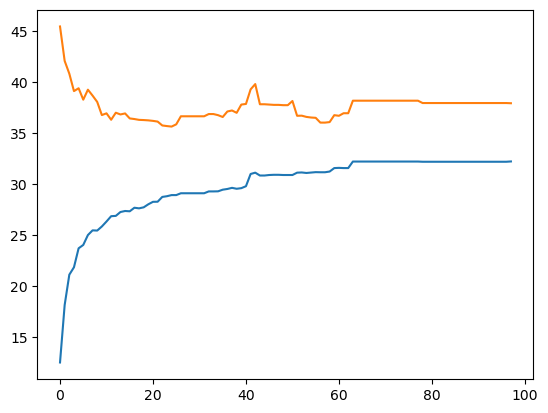

In [71]:
import matplotlib.pyplot as plt
plt.plot(tr)
plt.plot(ts)

In [72]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
modeller(rfr)

(11.79, 35.34)

In [73]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=30,max_depth=2)
modeller(rfr)

(30.98, 36.46)

In [74]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=30,max_depth=3)
modeller(rfr)

(28.21, 34.74)

In [75]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=30,max_depth=4)
modeller(rfr)

(25.75, 34.45)

In [76]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=30)
modeller(abr)

(31.59, 36.14)

In [77]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=40)
modeller(abr)

(32.78, 37.44)

In [78]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=50)
modeller(abr)

(32.16, 36.87)

In [79]:
from sklearn.neighbors import KNeighborsRegressor
tr = []
ts = []
for i in range(2,100,1):
    from sklearn.neighbors import KNeighborsRegressor
    knr = KNeighborsRegressor(n_neighbors=i)
    t1,t2 = modeller(knr)
    tr.append(t1)
    ts.append(t2)

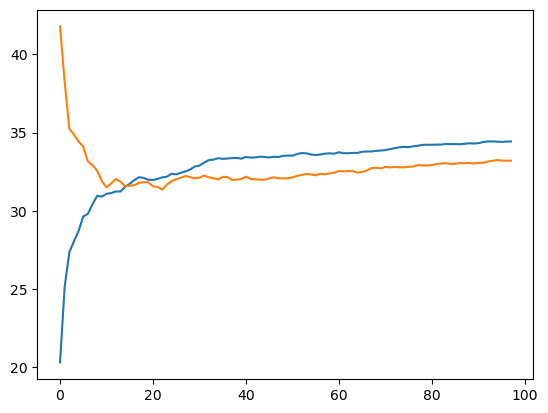

In [80]:
import matplotlib.pyplot as plt
plt.plot(tr)
plt.plot(ts)

In [81]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=17)
modeller(knr)

(31.73, 31.61)

# Final Model

In [82]:
knr = KNeighborsRegressor(n_neighbors=17)
model = knr.fit(Xnew,Y)

# Prepare prediction set

In [83]:
X = tsd

cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)
X1 = pd.DataFrame(ss.transform(X[con]),columns=con)
X2 = pd.get_dummies(X[cat])
Xnew2 = X1.join(X2)

In [84]:
len(Xnew.columns),len(Xnew2.columns)

(21, 21)

# Predictions

In [85]:
pred = model.predict(Xnew2)

In [86]:
tsd['LoanAmount_Approved_ten']=pred

In [87]:
tsd

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_Approved_ten
0,Male,Yes,0,Graduate,No,5720,0,360.0,1.0,Urban,Y,136.224960
1,Male,Yes,1,Graduate,No,3076,1500,360.0,1.0,Urban,Y,111.294118
2,Male,Yes,2,Graduate,No,5000,1800,360.0,1.0,Urban,Y,142.411765
3,Male,Yes,2,Graduate,No,2340,2546,360.0,1.0,Urban,Y,124.847774
4,Male,No,0,Not Graduate,No,3276,0,360.0,1.0,Urban,N,98.989666
...,...,...,...,...,...,...,...,...,...,...,...,...
362,Male,Yes,3+,Not Graduate,Yes,4009,1777,360.0,1.0,Urban,Y,123.823529
363,Male,Yes,0,Graduate,No,4158,709,360.0,1.0,Urban,Y,117.930843
364,Male,No,0,Graduate,No,3250,1993,360.0,1.0,Semiurban,Y,108.764706
365,Male,Yes,0,Graduate,No,5000,2393,360.0,1.0,Rural,N,153.588235


# Problem 2.2

In [88]:
Q = A[(A.Loan_Status=="N")]
Q.index = range(0,73)

In [89]:
Q['Duration']=Q.Loan_Amount_Term/12

In [90]:
R = Q[Q.Duration<=20]
R1 = R.drop(labels=["Duration"],axis=1)

In [91]:
A = trd[trd.Loan_Status=="Y"]
A.index = range(0,398,1)
X = A.drop(labels=["Loan_Amount_Term","Loan_ID","Loan_Status"],axis=1)
A['Duration']=A.Loan_Amount_Term/12
Y = A[["Duration"]]

In [92]:
cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(X[con]),columns=con)
X2 = pd.get_dummies(X[cat])
Xnew2 = X1.join(X2)

In [93]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew2,Y,test_size=0.2,random_state=21)

# Model

In [94]:
from sklearn.neighbors import KNeighborsRegressor
tr = []
ts = []
for i in range(2,100,1):
    from sklearn.neighbors import KNeighborsRegressor
    knr = KNeighborsRegressor(n_neighbors=i)
    t1,t2 = modeller(knr)
    tr.append(t1)
    ts.append(t2)

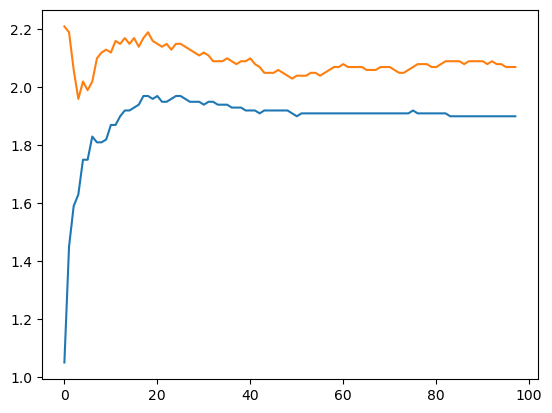

In [95]:
plt.plot(tr)
plt.plot(ts)

In [96]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=2)
modeller(knr)

(1.05, 2.21)

In [97]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=3)
modeller(knr)

(1.45, 2.19)

In [98]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=4)
modeller(knr)

(1.59, 2.06)

In [99]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=5)
modeller(knr)

(1.63, 1.96)

In [100]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=6)
modeller(knr)

(1.75, 2.02)

# Final Model

In [101]:
knr = KNeighborsRegressor(n_neighbors=5)
model = knr.fit(Xnew2,Y)

# Data

In [102]:
R1.index=range(0,7)

In [103]:
X = R1.drop(labels=["Loan_Amount_Term","Loan_ID","Loan_Status"],axis=1)

cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

X1 = pd.DataFrame(ss.transform(X[con]),columns=con)
X2 = pd.get_dummies(X[cat])
Xnew21 = X1.join(X2)

In [104]:
#Xnew21[Xnew2.columns]

In [105]:
W = ['Dependents_1', 'Property_Area_Rural', 'Gender_Female', 'Dependents_2']
for i in W:
    Xnew21[i]=0